# Introduction

In this notebook a model is generated for predicting building energy peformance as set out in the ASHRAE - Great Energy Predictor III competition. The analysis proceeds as follows:

<a href='#1'>1. Loading Data</a>

<a href='#2'>2. Missing Values</a>

<a href='#3'>3. Combining Datasets</a>

   <a href='#3.1'>3.1. Additional Missing Data</a>
    
<a href='#4'>4. Reducing Memory Requirements</a>

<a href='#5'>5. Adding Features</a>

<a href='#6'>6. Outlier Treatment</a>

<a href='#7'>7. Model Training</a>

<a href='#8'>8. Model Predictions</a>

# <a id='1'>1. Loading Data</a>

In [1]:
#import libraries
import pandas as pd
import numpy as np
import missingno as msno 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
#load data
train = pd.read_csv('ignoreThese/energyCSV/train.csv')
train['timestamp'] = pd.to_datetime(train['timestamp']) #the train dataset contains a 'timestamp' column we convert to a datetime object for ease of use
test = pd.read_csv('ignoreThese/energyCSV/test.csv')
test['timestamp'] = pd.to_datetime(test['timestamp'])
weather_train = pd.read_csv('ignoreThese/energyCSV/weather_train.csv')
weather_test = pd.read_csv('ignoreThese/energyCSV/weather_test.csv')
build_meta = pd.read_csv('ignoreThese/energyCSV/building_metadata.csv')

# <a id='2'>2. Missing Values</a>

The train and test data contains missing values and is spread out over several dataframes (meter readings, building meta-data, and weather data). Here we fill the missing values and combine the datsets into overall train/test sets for model training and prediction.

In [3]:
#Define a function to check if there are is any missing information in the datasets
def get_missing_info(df):
    num_entries = df.shape[0]*df.shape[1]
    null_entries = df.isnull().sum().sum()
    percent_empty = null_entries/num_entries*100
    num_missing = df.isna().sum()
    percent_missing = num_missing/len(df)*100
    col_modes = df.mode().loc[0]
    percent_mode = [df[x].isin([df[x].mode()[0]]).sum()/len(df)*100 for x in df]
    missing_value_df = pd.DataFrame({'num_missing': num_missing,
                                     'percent_missing': percent_missing, 
                                     'mode': col_modes,
                                     'percent_mode':percent_mode})
    print('total empty percent:', percent_empty, '%')
    print('columns that are more than 97% mode:', missing_value_df.loc[missing_value_df['percent_mode']>97].index.values)
    return(missing_value_df)

In [4]:
get_missing_info(train)
# get_missing_info(test)

total empty percent: 0.0 %
columns that are more than 97% mode: []


,num_missing,percent_missing,mode,percent_mode
building_id,0,0.0,1249,0.173802
meter,0,0.0,0,59.659925
timestamp,0,0.0,2016-12-27 22:00:00,0.011723
meter_reading,0,0.0,0,9.269721


There are no missing entries in the train or test dataframes.

In [5]:
get_missing_info(build_meta)

total empty percent: 21.486082355647575 %
columns that are more than 97% mode: []


,num_missing,percent_missing,mode,percent_mode
site_id,0,0.000000,3,18.909593
building_id,0,0.000000,0,0.069013
primary_use,0,0.000000,Education,37.888199
square_feet,0,0.000000,387638,0.483092
year_built,774,53.416149,1976,3.795721
floor_count,1094,75.500345,1,7.522429


In [6]:
#Filling in missing values in the building meta-data column
#Make a copy so we are not changing the initial data
build_meta_f = build_meta.copy()
#fill all the missing floor counts by the mode (1) and the missing year built by the mean. Nothing else is missing
build_meta_f.fillna({'floor_count':1, 'year_built':int(build_meta['year_built'].mean())}, inplace=True) 
#this is the only categorical column. Convert so it can be handled later by lgbm during fitting
build_meta_f['primary_use'] = build_meta_f['primary_use'].astype('category') 

In [7]:
get_missing_info(weather_train)
# get_missing_info(weather_test)

total empty percent: 10.876365408356566 %
columns that are more than 97% mode: []


,num_missing,percent_missing,mode,percent_mode
site_id,0,0.000000,0,6.284476
timestamp,0,0.000000,2016-01-01 01:00:00,0.011447
air_temperature,55,0.039350,15,1.947443
cloud_coverage,69173,49.489529,0,24.232863
dew_temperature,113,0.080845,10,1.973915
precip_depth_1_hr,50289,35.979052,0,55.740379
sea_level_pressure,10618,7.596603,1015.2,0.608844
wind_direction,6268,4.484414,0,9.410974
wind_speed,304,0.217496,2.1,10.288825


When filling the missing weather data, using previous or future measurements can be good provided they are not too far in the future or past. We will start with forward/back filling weather data up to 24 hours for each site.

In [8]:
#Forward filling missing data in the weather dataset +-24 hours
#Train weather
weather_train_f = weather_train.copy() #make a copy so we aren't changing our oridinal data
weather_train_f['timestamp'] = pd.to_datetime(weather_train_f['timestamp']) #turn the timestamp column into a datetime object
weather_train_f = weather_train_f.sort_values(by=['site_id', 'timestamp']) #short values by site id then timestamp

#test weather
weather_test_f = weather_test.copy() #make a copy so we aren't changing our oridinal data
weather_test_f['timestamp'] = pd.to_datetime(weather_test_f['timestamp']) #turn the timestamp column into a datetime object
weather_test_f = weather_test_f.sort_values(by=['site_id', 'timestamp']) #short values by site id then timestamp

weather_train_f.fillna(method = 'ffill', inplace=True, limit = 24)#forward fill the missing data up to 12 hours
weather_train_f.fillna(method = 'bfill', inplace=True, limit = 24)#backfill up to 12 hours

weather_test_f.fillna(method = 'ffill', inplace=True, limit = 24)#forward fill the missing data up to 12 hours
weather_test_f.fillna(method = 'bfill', inplace=True, limit = 24)#forward fill the missing data up to 12 hours

In [9]:
get_missing_info(weather_train_f)

total empty percent: 5.124658474017792 %
columns that are more than 97% mode: []


,num_missing,percent_missing,mode,percent_mode
site_id,0,0.000000,0,6.284476
timestamp,0,0.000000,2016-01-01 01:00:00,0.011447
air_temperature,0,0.000000,15,1.947443
cloud_coverage,20378,14.579354,0,36.310303
dew_temperature,0,0.000000,10,1.975346
precip_depth_1_hr,35309,25.261674,0,55.996509
sea_level_pressure,8779,6.280898,1015.2,0.617430
wind_direction,0,0.000000,0,10.343199
wind_speed,0,0.000000,2.1,10.333183


<AxesSubplot:>

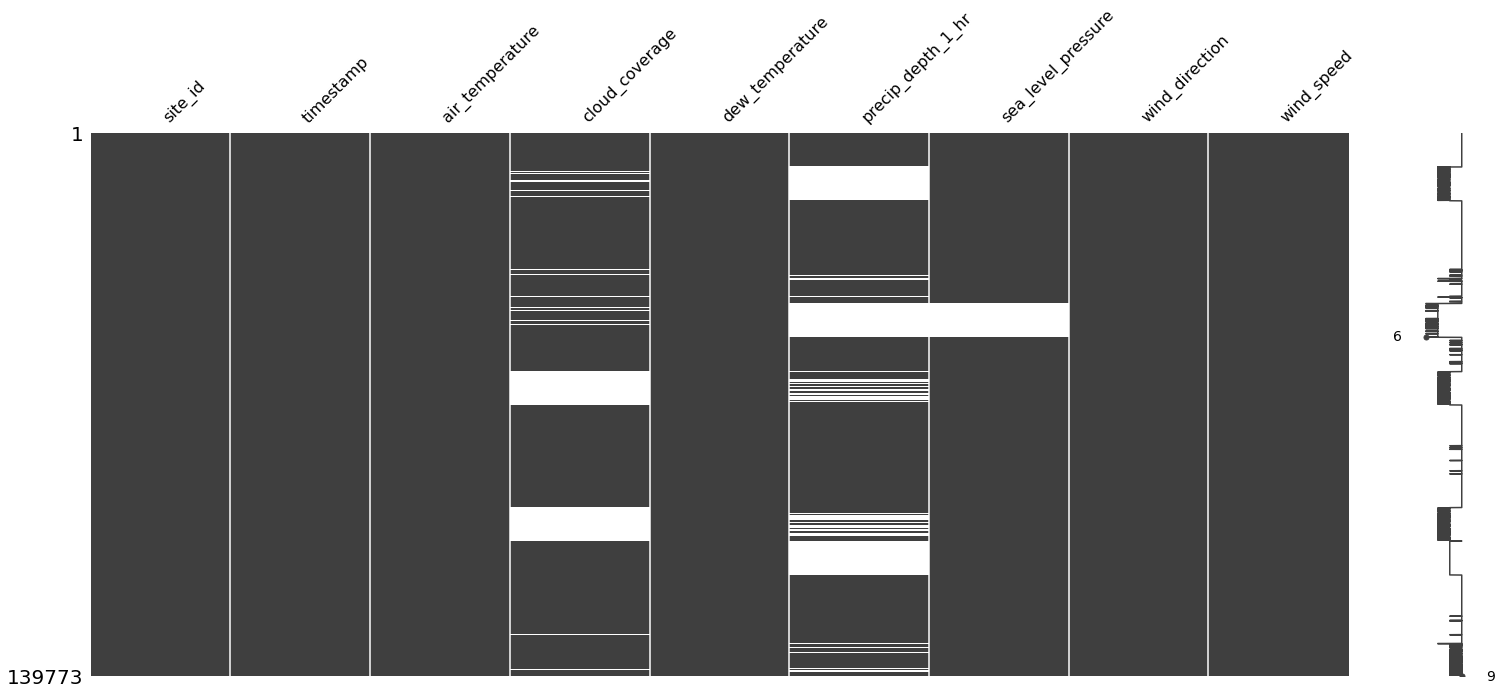

In [10]:
msno.matrix(weather_train_f)
# msno.matrix(weather_test_f)

As seen above, there are still blocks of data missing over long periods of time. For these we will fill with the mean values for the given site.

In [11]:
#Train data
missing_cols = [col for col in weather_train_f.columns if weather_train_f[col].isna().any()] 
fill_lib = weather_train_f.groupby('site_id')[missing_cols].transform('mean')#stores the mean of each feature for each site id
weather_train_f.fillna(fill_lib, inplace=True) #for each feature with missing values, fill the missing entry with the mean for that site

#Test data
missing_cols = [col for col in weather_test_f.columns if weather_test_f[col].isna().any()]
fill_lib = weather_test_f.groupby('site_id')[missing_cols].transform('mean')
weather_test_f.fillna(fill_lib, inplace=True)

# <a id='3'>3. Combining Datasets</a>
Now that we have filled in all the missing data, we will merge everything into train and test dataframes.

In [12]:
#merge the building meta data and weather data into the train data
train_m = train.merge(build_meta_f, how='left', on = ['building_id'], validate='many_to_one') #merge the building meta data into the train data
train_m = train_m.merge(weather_train_f, how='left', on = ['site_id', 'timestamp'], validate='many_to_one')#add weather data to each time entry for each site ID

#merge the building meta data and weather data into the test data
test_m = test.merge(build_meta_f, how='left', on = ['building_id'], validate='many_to_one') #merge the building meta data into the train data
test_m = test_m.merge(weather_test_f, how='left', on = ['site_id', 'timestamp'], validate='many_to_one')#add weather data to each time entry for each site ID

#we now delete some of the dataframes we no longer need to free up memory
del train, test, weather_train, weather_test, weather_train_f, weather_test_f, build_meta
import gc
gc.collect()

train_m.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,1.0,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,1.0,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,1.0,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,1.0,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,1.0,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0


<a id='3.1'>3.1. Additional Missing Data</a>

In [13]:
get_missing_info(train_m)
#get_missing_info(test_m)

total empty percent: 0.19584174247258374 %
columns that are more than 97% mode: []


,num_missing,percent_missing,mode,percent_mode
building_id,0,0.000000,1249,0.173802
meter,0,0.000000,0,59.659925
timestamp,0,0.000000,2016-12-27 22:00:00,0.011723
meter_reading,0,0.000000,0,9.269721
site_id,0,0.000000,13,13.413878
primary_use,0,0.000000,Education,40.391094
square_feet,0,0.000000,387638,0.304154
year_built,0,0.000000,1967,60.841488
floor_count,0,0.000000,1,87.274351
air_temperature,90495,0.447638,24.4,1.958662


We can now see some additional missing data in the merged datasets from timestamps present in the train/test sets that
were not in the weather data. We will forward fill this data for each building.

In [14]:
#train_data
train_m = train_m.sort_values(by=['building_id', 'timestamp'])
train_m.fillna(method = 'ffill', inplace=True)

#we need to temporarily remove the train_m datset from memory here so we do not run out of memory
pickle.dump( train_m, open( "train_m.p", "wb" ) )
del train_m

#test data
test_m = test_m.sort_values(by=['building_id', 'timestamp'])
test_m.fillna(method = 'ffill', inplace=True)

train_m = pickle.load( open('train_m.p', 'rb')) #load back in the train data

# <a id='4'>4. Reducing Memory Requirements</a>

We can reduce the size of our data by changing the datatype based on the precision required by the numbers. Below we use a custom function to achieve this. Source: https://www.kaggle.com/caesarlupum/ashrae-start-here-a-gentle-introduction

In [15]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

train_m = reduce_mem_usage(train_m)
test_m = reduce_mem_usage(test_m)

Mem. usage decreased to 906.14 Mb (63.6% reduction)
Mem. usage decreased to 1869.00 Mb (63.6% reduction)


# <a id='5'>5. Adding Features</a>

In [16]:
#Add hour, time of year, and weekend columns
#Train
train_m['hour'] = train_m['timestamp'].dt.hour
train_m['day_of_year'] = (train_m['timestamp'] - pd.Timestamp('2016-01-01')).dt.days%365
train_m['is_weekend'] = train_m['timestamp'].dt.weekday.isin([5,6]).astype(int)

#Test
test_m['hour'] = test_m['timestamp'].dt.hour
test_m['day_of_year'] = (test_m['timestamp'] - pd.Timestamp('2016-01-01')).dt.days%365
test_m['is_weekend'] = test_m['timestamp'].dt.weekday.isin([5,6]).astype(int)

# <a id='6'>6. Outlier Treatment</a>

Below we look at the buildings which tend to have the highest meter readings for each meter type. As we can see, relatively few buildings tend to dominate in terms of meter reading. As an example, building 803 has an average meter reading 0 roughly 20x the average.

In [17]:
for m in range(4):
    idxm = train_m[train_m['meter']==m].groupby('timestamp')['meter_reading'].idxmax()#index of max meter reading for the timestamp
    print('meter {}'.format(m))
    #print the number of hours the building was the highest consumer for the top 5 buildings
    print(train_m.loc[idxm, 'building_id'].value_counts().iloc[:5]) 

meter 0
803     3157
801     2665
799     1446
1088    1196
794      248
Name: building_id, dtype: int64
meter 1
1284    3292
76      2139
1258     958
1289     909
778      830
Name: building_id, dtype: int64
meter 2
1099    3281
1197    2980
1168    2263
1148     258
1140       1
Name: building_id, dtype: int64
meter 3
1021    3694
1331    3634
794      522
1317     311
1235     111
Name: building_id, dtype: int64


In [18]:
print('Mean meter 0 reading: outlier building #803')
print(train_m[(train_m['building_id']==803) & (train_m['meter']==0)]['meter_reading'].mean())
print('Mean meter 0  reading: overall')
print(train_m[(train_m['meter']==0)]['meter_reading'].mean())

Mean meter 0 reading: outlier building #803
3613.62
Mean meter 0  reading: overall
170.82565


Outliers can produce outsized error terms in a model that fits the rest of the data well. To address this, we will rescale the target variable (meter reading) for each building and meter type. 

The overall average meter reading is about 2000 so we will rescale to the range (0,2000). Note that the scale we choose has an effect on model training because the evaluation metric (root mean squared log error) is sensitive to the scale of the numbers.

In [19]:
#We would like to rescale the meter reading column for each building and meter reading to prevent outliers from skewing the reults.
#This is a class to achieve that for any chosen groups. It is a modified version of code by Szymon Maszke: 
#https://stackoverflow.com/questions/55601928/apply-multiple-standardscalers-to-individual-groups
from sklearn.base import clone
class GroupTargetTransform:
    def __init__(self, transformation):
        self.transformation = transformation
        self._group_transforms = {} #this library will hold the group transforms

    def _call_with_function(self, X, y, function: str):
        yhat = pd.Series(dtype = 'float32')#this will hold the rescaled target data
        X['target'] = pd.Series(y, index=X.index)
        for gr in X.groupby(self.features):
            n = gr[0] #this is a tuple id for the group
            g_X = gr[1] #this is the group dataframe
            g_yhat = getattr(self._group_transforms[n], function)(g_X['target'].values.reshape(-1,1))#scale the target variable
            g_yhat = pd.Series(g_yhat.flatten(), index = g_X.index)
            yhat = yhat.append(g_yhat)
        X.drop('target', axis=1, inplace = True)
        return yhat.sort_index()
    
    def fit(self, X, y, features):
        self.features = features
        X['target'] = pd.Series(y, index=X.index) 
        for gr in X.groupby(self.features):
            n = gr[0] #this is a tuple id for the group
            g_X = gr[1] #this is the group dataframe
            sc = clone(self.transformation) #create a new instance of the transform
            self._group_transforms[n] = sc.fit(g_X['target'].values.reshape(-1,1))
        X.drop('target', axis=1, inplace=True)
        return self

    def transform(self, X, y):
        return self._call_with_function(X, y, "transform")

    def fit_transform(self, X, y, features):
        self.fit(X, y, features)
        return self.transform(X, y)

    def inverse_transform(self, X, y):
        return self._call_with_function(X, y, "inverse_transform")

In [20]:
#rescale the target variable for each building and meter type.
from sklearn.preprocessing import MinMaxScaler

scaler = GroupTargetTransform(MinMaxScaler(feature_range = (0,2000))) #2000 is roughly the average meter reading for all the train data
train_m['meter_reading_rescaled'] = scaler.fit_transform(train_m, train_m['meter_reading'], ['building_id', 'meter'])
#convert to log(y+1) so the RMSE evaluation metric is actually giving the RMSLE (teh evaluation metric for the competition)
train_m['meter_reading_rescaled'] = np.log1p(train_m['meter_reading_rescaled']) 

# <a id='7'>7. Model Training</a>

In [21]:
# Save test and train data onto the HDD so we can free up some memory
import pickle
pickle.dump( test_m, open( "test_m.p", "wb" ) )
pickle.dump( train_m, open( "train_m.p", "wb" ) )
del test_m

Below we will tune the model parameters and get an idea of how well the model can perform on unseen data. We have done this by:

* Holding out the last 2.5 months of data for validation
* Holding out 10% of the buildings for validation
* Cross-validating time-series wise (for parameter tuning)


In [22]:
%%time
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from lightgbm import LGBMRegressor
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, mean_squared_log_error

#defining a couple of functions for later use
def clip(x):
    return np.clip(x, a_min=0, a_max=None)
def rmse(y, y_pred):
    out = np.sqrt(mean_squared_error(clip(y), clip(y_pred)))
    return out

#prepare training data
X = train_m.dropna(subset=['meter_reading']) #drop all rows where the meter reading is not included
X = X.sort_values(by=['timestamp'], axis=0) #ensure X is sorted by timstamp for later timeseries cross-validation

builds = X['building_id'].unique()#array of building ids in the dataset
build_train, build_val = train_test_split(builds, test_size = 0.1, random_state=0)#hold out 10% of the buildings for validation

train = X.loc[(X['timestamp']<'2016-10-15') 
          & (X['building_id'].isin(build_train))] #we will train on only the first 80% of the year and 90% buildings
val_t = X.loc[(X['timestamp']>='2016-10-15') & (X['building_id'].isin(build_train))] #rest of the year and same buildings as above
val_b = X.loc[(X['building_id'].isin(build_val))] #full year and the rest of the buildings

y_train, y_val_t, y_val_b = train['meter_reading_rescaled'], val_t['meter_reading'], val_b['meter_reading'] #extracting the meter reading as our target variable
X_train, X_val_t, X_val_b = train.drop(['meter_reading', 'meter_reading_rescaled', 'timestamp'], axis=1), val_t.drop(['meter_reading', 'meter_reading_rescaled','timestamp'], axis=1), val_b.drop(['meter_reading','meter_reading_rescaled','timestamp'], axis=1)

del X, train, val_t, val_b #no longer needed - free up memory

# lgbm model
model = LGBMRegressor(
num_leaves = 600,
min_data_in_leaf = 50,
random_state = 0
)

#cross-validation for paramter tuning
# params = {
#     'num_leaves': [600],#add values to these lists to run a parmaeter optimization. These were found to be optimum.
#          }

# #define a rmse scorer for gridsearchcv
# rmse_scorer = make_scorer(rmse, greater_is_better=False)
# #split training data time series-wise for cross-validation
# tscv = TimeSeriesSplit(n_splits=3)
# #grid search
# #Note that the scores given are based on the rescaled meter readings, so are not a direct representation of model performance
# for model_name, grid in params.items():
#     searchCV = GridSearchCV(model, scoring=rmse_scorer, cv=tscv, param_grid=params)
#     print('GridSearchCV fitting...')
#     searchCV.fit(X_train, y_train)
#     scores = -1*searchCV.cv_results_['mean_test_score']
#     params = searchCV.cv_results_['params']
#     for i in range(0, len(scores)):
#       print(params[i], '->', scores[i])

#Evaluate combined model on the ramining validation data
print('Fitting...')
model.fit(X_train, y_train)

print('Time predictions...')
preds = clip(model.predict(X_val_t)) #make time predictions
preds_inv = scaler.inverse_transform(X_val_t, np.expm1(preds)) #convert back to original scale, remembering to invert the log transform
y_val_t = y_val_t.sort_index()
score = mean_absolute_error(preds_inv, y_val_t)
print('Mean absolute error - time prediction:', score)
RMSLE = np.sqrt(mean_squared_log_error(preds_inv, y_val_t))
print('RMSLE - time prediction:', RMSLE)

print('Building predictions...')
preds = clip(model.predict(X_val_b))
preds_inv = scaler.inverse_transform(X_val_b, np.expm1(preds))
y_val_b = y_val_b.sort_index()
score = mean_absolute_error(preds_inv, y_val_b)
print('Mean absolute error - new buildings:', score)
RMSLE = np.sqrt(mean_squared_log_error(preds_inv, y_val_b))
print('RMSLE - new buildings:', RMSLE)

Fitting...
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
Time predictions...
Mean absolute error - time prediction: 237.43585079374566
RMSLE - time prediction: 1.3016481970633507
Building predictions...
Mean absolute error - new buildings: 18135.414450166376
RMSLE - new buildings: 1.4916646635068394
Wall time: 1min 48s


Now that we have tuned the model parameters and have an idea of model performance. We will fit on the entire training dataset so we have as much information as possible for the final test set prediction.

In [23]:
#prepare training data
train = train_m.dropna(subset=['meter_reading']) #drop all rows where the meter reading is not included

y_train = train['meter_reading_rescaled'] #extracting the meter reading as our target variable
X_train = train.drop(['meter_reading', 'meter_reading_rescaled', 'timestamp'], axis=1)

del train, train_m, X_val_t #no longer needed - free up memory
gc.collect()

#Fitting on all training data
print('Final Fitting...')
model.fit(X_train, y_train)

Final Fitting...
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


LGBMRegressor(min_data_in_leaf=50, num_leaves=600, random_state=0)

# <a id='8'>8. Model Predictions</a>

In [24]:
#free up memory then load in the test data
del X_train, y_train
gc.collect()
X_test = pickle.load( open( "test_m.p", "rb" ) )

In [34]:
X_test

NameError: name 'test_m' is not defined

In [25]:
#output the final predictions on the test data to a csv file
preds = np.empty(len(X_test))#we will predict in three steps to save memory
print('A')
preds[:int(len(X_test)/3)] = model.predict(X_test.drop(['row_id', 'timestamp'], axis=1).iloc[:int(len(X_test)/3)])
preds[int(len(X_test)/3):int(len(X_test)*2/3)] = model.predict(X_test.drop(['row_id', 'timestamp'], axis=1).iloc[int(len(X_test)/3):int(len(X_test)*2/3)])
preds[int(len(X_test)*2/3):] = model.predict(X_test.drop(['row_id', 'timestamp'], axis=1).iloc[int(len(X_test)*2/3):])
final_predictions = scaler.inverse_transform(X_test, np.expm1(preds))
X_test = X_test.sort_index()
output = pd.DataFrame({'row_id': X_test['row_id'], 'meter_reading': clip(final_predictions)})
output['meter_reading'] = output['meter_reading'].round(decimals=4)#to save space
output.to_csv('sub.csv', index_label = 'row_id', index=False)

A


As a final check, we can plot the model predictions with the existing data for a specific building and meter type. Everything during 2016 is real data while the rest is our final predictions.

<AxesSubplot:xlabel='timestamp'>

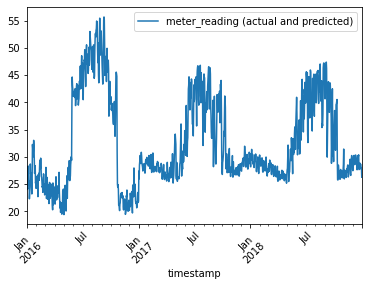

In [26]:
b_id = 400 #building id
m_id = 0 #meter id

train_m = pickle.load( open('train_m.p', 'rb'))
building_current = train_m.loc[(train_m['building_id']==b_id) & (train_m['meter']==m_id)]
building_forecast = X_test.loc[(X_test['building_id']==b_id) & (X_test['meter']==m_id)].merge(output, how='left', on = ['row_id'], validate='one_to_one')
building = pd.concat([building_current, building_forecast])

X_o = building.drop(['meter_reading', 'row_id', 'timestamp', 'site_id'], axis=1)
y_o = building['meter_reading']

mod_plot = pd.DataFrame(data={#'meter_reading (predicted)':building_forecast['meter_reading'],
                                    'meter_reading (actual and predicted)':y_o.values},
                                    index=building['timestamp'])
start_time = '2016-01-01'
end_time = '2019-01-01'
mod_plot = mod_plot.loc[(start_time<mod_plot.index)&(mod_plot.index<end_time)].resample('D').mean()
mod_plot.plot(rot=45)#plot each model vs target

In [27]:
output

,row_id,meter_reading
0,0,0.0111
1,1,0.0061
2,2,0.0016
3,3,0.0244
4,4,0.1316
...,...,...
41697595,41697595,5.9310
41697596,41697596,4.7616
41697597,41697597,2.6756
41697598,41697598,181.1938


In [28]:
train_m

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day_of_year,is_weekend,meter_reading_rescaled
0,0,0,2016-01-01 00:00:00,0.000,0,Education,7432,2008.0,1.0,25.000000,6.0,20.000000,-1.0,1019.5,0.0,0.000000,0,0,0,0.000000
2301,0,0,2016-01-01 01:00:00,0.000,0,Education,7432,2008.0,1.0,24.406250,6.0,21.093750,-1.0,1020.0,70.0,1.500000,1,0,0,0.000000
4594,0,0,2016-01-01 02:00:00,0.000,0,Education,7432,2008.0,1.0,22.796875,2.0,21.093750,0.0,1020.0,0.0,0.000000,2,0,0,0.000000
6893,0,0,2016-01-01 03:00:00,0.000,0,Education,7432,2008.0,1.0,21.093750,2.0,20.593750,0.0,1020.0,0.0,0.000000,3,0,0,0.000000
9189,0,0,2016-01-01 04:00:00,0.000,0,Education,7432,2008.0,1.0,20.000000,2.0,20.000000,-1.0,1020.0,250.0,2.599609,4,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20206636,1448,0,2016-12-31 19:00:00,3.400,15,Office,92271,2001.0,1.0,3.000000,0.0,-8.000000,-1.0,1007.5,180.0,5.699219,19,0,1,6.681226
20209002,1448,0,2016-12-31 20:00:00,2.700,15,Office,92271,2001.0,1.0,2.800781,2.0,-8.898438,-1.0,1007.5,180.0,7.699219,20,0,1,6.287928
20211367,1448,0,2016-12-31 21:00:00,3.050,15,Office,92271,2001.0,1.0,2.800781,2.0,-7.199219,-1.0,1007.5,180.0,5.101562,21,0,1,6.503789
20213733,1448,0,2016-12-31 22:00:00,3.125,15,Office,92271,2001.0,1.0,2.199219,2.0,-6.699219,-1.0,1008.0,170.0,4.601562,22,0,1,6.544551


In [29]:
get_missing_info(train_m)

total empty percent: 0.0 %
columns that are more than 97% mode: []


,num_missing,percent_missing,mode,percent_mode
building_id,0,0.0,1249,0.173802
meter,0,0.0,0,59.659925
timestamp,0,0.0,2016-12-27 22:00:00,0.011723
meter_reading,0,0.0,0,9.269721
site_id,0,0.0,13,13.413878
primary_use,0,0.0,Education,40.391094
square_feet,0,0.0,387638,0.304154
year_built,0,0.0,1967,60.841488
floor_count,0,0.0,1,87.274351
air_temperature,0,0.0,24.4062,1.964083
